In [1]:
import xmltodict
import pathlib
import collada
import shapely
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import mio
from shapely.geometry import Polygon
import numpy as np

In [2]:
# switch of Collada warnings
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
def plot_trilist(l, tab_name):
    lgeom = []
    ldic = []
    for v in l:
        x0, y0, z0 = v[0]
        x1, y1, z1 = v[1]
        x2, y2, z2 = v[2]
        p = Polygon([(x0,y0), (x1,y1), (x2, y2)])
        lgeom.append(p)
        dic = {
            'x0':x0, 'y0':y0, 'z0':z0,
            'x1':x1, 'y1':y1, 'z0':z1,
            'x2':x2, 'y2':y2, 'z2':z2,
        }
        ldic.append(dic)
    gdf = gpd.GeoDataFrame(ldic, geometry=lgeom)
    mio.write_tab(gdf, tab_name)
    gdf.plot()

In [4]:
def dae2list(model_path):
    """read dae file and return triangle list"""
    model_path = str(model_path)
    result = []
    try:
        mesh = collada.Collada(model_path)
    except:
        print('can not create collada', model_path)
        return None
    for geom in mesh.geometries:
        for triset in geom.primitives:
            for tri_obj in triset:
                tri = []
                for vertex in tri_obj.vertices:
                    vertex = list(vertex)
                    tri.append(vertex)
                result.append(tri)
    return result

50 row(s) written to mapinfo file.


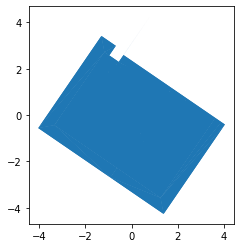

In [5]:
l = dae2list(r"C:\loc\_SwissBuildings\KML\1011-34\models\model.dae",)
plot_trilist(l, 'test1.tab')

In [6]:
l[0:3]

[[[1.25389, -3.574127, 493.796],
  [2.3489861, 0.7440647, 494.506],
  [-0.6317002, -2.2827718, 494.851]],
 [[2.3489861, 0.7440647, 494.506],
  [1.7326794, 1.166352, 494.851],
  [-0.6317002, -2.2827718, 494.851]],
 [[3.617283, -0.12398981, 493.796],
  [2.3489861, 0.7440647, 494.506],
  [1.25389, -3.574127, 493.796]]]

In [7]:
def get_coords_df(kml_path):
    """read kml and return dataframe with coords and model name"""
    with open(kml_path) as fin:
        skml = fin.read()
    dic = xmltodict.parse(skml)
    pms = dic['kml']['Document']['Placemark']
    
    dics = []
    
    # only one model
    if 'Model' in pms:
        pms = [pms]
        
    for pm in pms:
        model = pm['Model']
        lon = pm['Model']['Location']['longitude']
        lat = pm['Model']['Location']['latitude']
        model = pm['Model']['Link']['href']
        dic = {
            'lon' : lon, 
            'lat' : lat,
            'model' : model
        }
        dics.append(dic)
    #breakpoint()
    df = pd.DataFrame(dics)
    
    # add swiss coordinates
    coords = list(zip(df.lon, df.lat))
    coords = [mio.wgs_swiss(*ll) for ll in coords]
    coords = list(zip(*coords))
    df['x'] = coords[0]
    df['y'] = coords[1]
    return df

In [8]:
def make_tris(kml_path):
    df = get_coords_df(kml_path)
    folder = pathlib.Path(kml_path).parent
    ldic = []
    for ind, row in df.iterrows():
        dx, dy = row.x, row.y
        tris = dae2list(folder / row.model)
        if tris is None:
            continue
        n = -1
        for tri in tris:
            n += 1
            x0, y0 ,z0 = tri[0]
            x1, y1 ,z1 = tri[1]
            x2, y2 ,z2 = tri[2]
            x0, y0, z0 = np.round(float(x0) + dx, 2), np.round(float(y0) + dy, 2), np.round(float(z0), 2)
            x1, y1, z1 = np.round(float(x1) + dx, 2), np.round(float(y1) + dy, 2), np.round(float(z1), 2)
            x2, y2, z2 = np.round(float(x2) + dx, 2), np.round(float(y2) + dy, 2), np.round(float(z2), 2)
            dic = {
                'model' : row.model,
                'tri' : n,
                'x0' : x0, 'y0' : y0,'z0' : z0,
                'x1' : x1, 'y1' : y1,'z1' : z1,
                'x2' : x2, 'y2' : y2,'z2' : z2,
            }
            ldic.append(dic)
    return pd.DataFrame(ldic)

50 row(s) written to mapinfo file.


<AxesSubplot:>

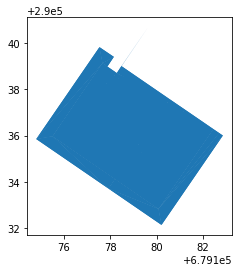

In [9]:
df = make_tris(r"C:\loc\_SwissBuildings\KML\1011-34\1011-34.kml")
dfm = df[df.model=='models/model.dae']
lgeom = []
ldic = []
for ind, row in dfm.iterrows():
    x0, y0, z0 = row.x0, row.y0, row.z0
    x1, y1, z1 = row.x1, row.y1, row.z1
    x2, y2, z2 = row.x2, row.y2, row.z2
    p = Polygon([(x0,y0), (x1,y1), (x2, y2)])
    lgeom.append(p)
    dic = {
    'x0':x0, 'y0':y0, 'z0':z0,
    'x1':x1, 'y1':y1, 'z0':z1,
    'x2':x2, 'y2':y2, 'z2':z2,
    }
    ldic.append(dic)
gdf = gpd.GeoDataFrame(ldic, geometry=lgeom)
mio.write_tab(gdf, 'test2.tab')
gdf.plot()

In [10]:
gdf.head(5)

,x0,y0,z0,x1,y1,x2,y2,z2,geometry
0.0,679180.08,290032.83,494.51,679181.18,290037.15,679178.20,290034.12,494.85,"POLYGON ((679180.080 290032.830, 679181.180 29..."
1.0,679181.18,290037.15,494.85,679180.56,290037.57,679178.20,290034.12,494.85,"POLYGON ((679181.180 290037.150, 679180.560 29..."
2.0,679182.45,290036.28,494.51,679181.18,290037.15,679180.08,290032.83,493.80,"POLYGON ((679182.450 290036.280, 679181.180 29..."
3.0,679180.21,290032.14,493.80,679180.08,290032.83,679177.92,290033.71,494.85,"POLYGON ((679180.210 290032.140, 679180.080 29..."
4.0,679177.92,290033.71,493.80,679180.08,290032.83,679178.20,290034.12,494.85,"POLYGON ((679177.920 290033.710, 679180.080 29..."


In [11]:
# get all kml paths
kml_paths = []
for dir in pathlib.Path('KML').glob("*"):
    for kml_path in dir.glob("*.kml"):
        kml_paths.append(kml_path)
iall = len(kml_paths)
iall

3221

In [12]:
%%time
# 19h
for i, kml_path in enumerate(kml_paths):
    mio.show_perc(i, iall, 10)      
    rdf = make_tris(kml_path)
    stem = pathlib.Path(kml_path).stem
    rdf.to_csv(f'tris/{stem}.tri', index=None)

0.0% 0.31% 0.62% can not create collada KML\1031-41\models\model_731.dae
0.93% 1.24% 1.55% can not create collada KML\1047-34\models\model_9673.dae
1.86% 2.17% 2.48% 2.79% can not create collada KML\1051-34\models\model_1632.dae
3.1% 3.42% 3.73% 4.04% 4.35% 4.66% 4.97% 5.28% can not create collada KML\1067-31\models\model_1745.dae
5.59% can not create collada KML\1068-24\models\model_382.dae
5.9% can not create collada KML\1068-33\models\model_337.dae
6.21% 6.52% 6.83% can not create collada KML\1070-33\models\model_447.dae
can not create collada KML\1070-41\models\model_1830.dae
7.14% can not create collada KML\1071-12\models\model_1238.dae
7.45% can not create collada KML\1071-44\models\model_1056.dae
7.76% 8.07% 8.38% 8.69% 9.0% 9.31% 9.62% 9.93% 10.25% can not create collada KML\1085-44\models\model_1030.dae
10.56% can not create collada KML\1086-32\models\model_1004.dae
10.87% 11.18% 11.49% 11.8% 12.11% can not create collada KML\1089-21\models\model_148.dae
can not create collada

In [13]:
# ca. 16.5 h